In [30]:
#from tensorflow.keras.datasets import cifar10
from tensorflow.keras.datasets import cifar100
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import keras_tuner as kt
import tensorflow as tf
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

Exploração inicial

In [5]:
#(x_train, y_train), (x_test, y_test) = cifar10.load_data()
(x_train, y_train), (x_test, y_test) = cifar100.load_data()

print("---------Cifar 100---------")
print(f"Train shape: {x_train.shape}")
print(f"Test shape: {x_test.shape}")
print(f"Min: {x_train.min()}")
print(f"Max: {x_train.max()}")
print(f"Média: {x_train.mean():.2f}")
print(f"Desvio Padrão: {x_train.std():.2f}")

#print("---------Cifar 10---------")
#print(f"Train shape: {x_train.shape}")
#print(f"Test shape: {x_test.shape}")
#print(f"Min: {x_train.min()}")
#print(f"Max: {x_train.max()}")
#print(f"Média: {x_train.mean():.2f}")
#print(f"Desvio Padrão: {x_train.std():.2f}")

x_train = x_train.astype('float32')/255.0
x_test = x_test.astype('float32')/255.0

#x_train2 = x_train2.astype('float32')/255.0
#x_test2 = x_test2.astype('float32')/255.0

169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
---------Cifar 100---------
Train shape: (50000, 32, 32, 3)
Test shape: (10000, 32, 32, 3)
Min: 0
Max: 255
Média: 121.94
Desvio Padrão: 68.39


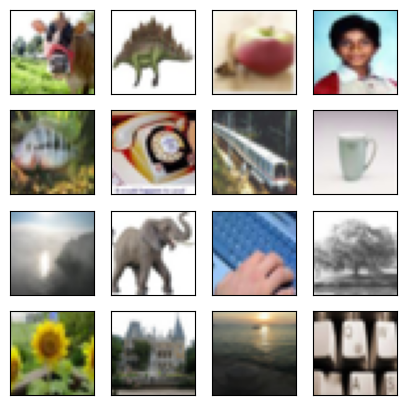

In [6]:
plt.figure(figsize = (5,5))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i])
plt.show()

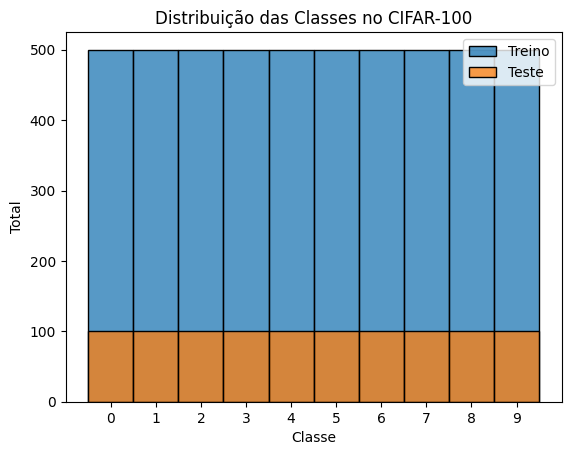

In [7]:
sns.histplot(y_train.flatten(), bins = np.arange(11)-0.5)
#sns.histplot(y_train2.flatten(), bins = np.arange(11)-0.5)
plt.xticks(range(10))

sns.histplot(y_test.flatten(), bins = np.arange(11)-0.5)
#sns.histplot(y_test2.flatten(), bins = np.arange(11)-0.5)
plt.xticks(range(10))
plt.xlabel("Classe")
plt.ylabel("Total")
plt.title("Distribuição das Classes no CIFAR-100")
plt.legend(["Treino", "Teste"])
plt.show()

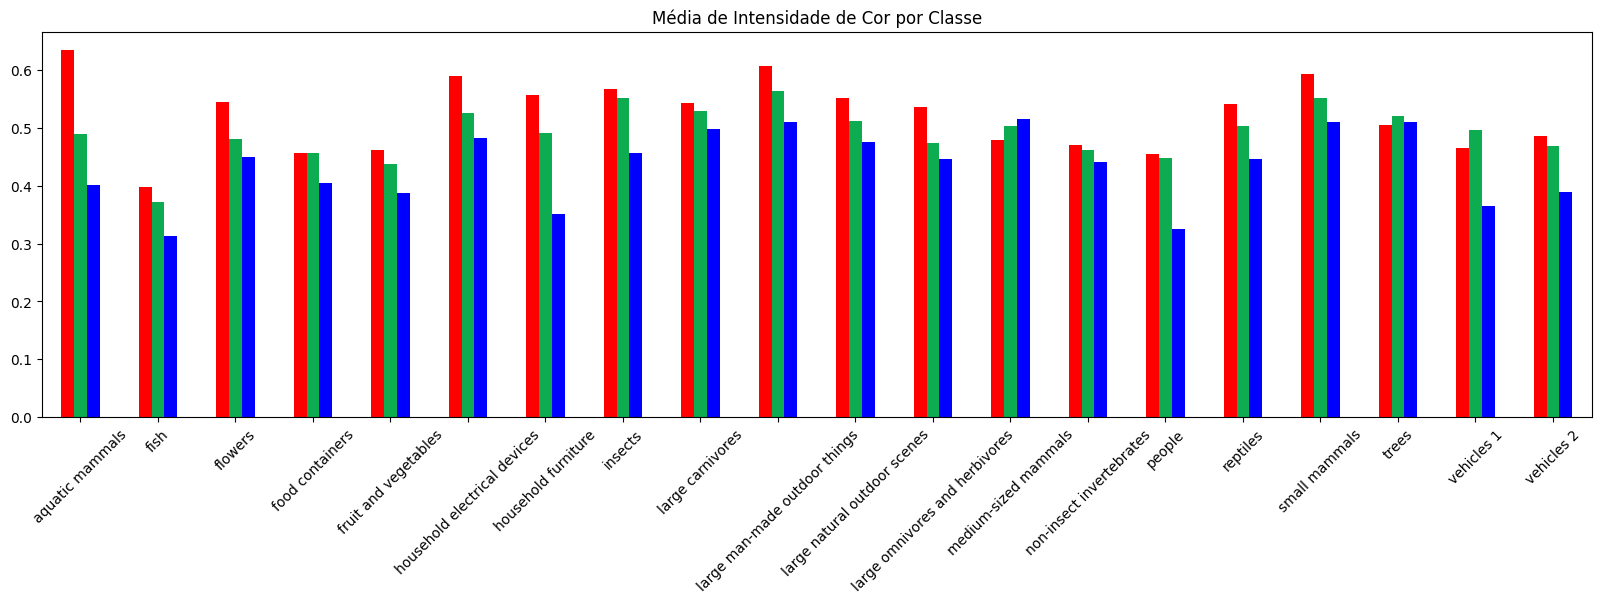

In [8]:
#names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
names = ['aquatic mammals', 'fish', 'flowers', 'food containers', 'fruit and vegetables', 'household electrical devices',
         'household furniture', 'insects', 'large carnivores', 'large man-made outdoor things', 'large natural outdoor scenes',
         'large omnivores and herbivores', 'medium-sized mammals', 'non-insect invertebrates', 'people', 'reptiles', 'small mammals',
         'trees', 'vehicles 1', 'vehicles 2']

means = {c: np.mean(x_train[y_train.flatten() == i], axis=(0, 1, 2)) for i, c in enumerate(names)}
#means = {c: np.mean(x_train2[y_train2.flatten() == i], axis=(0, 1, 2)) for i, c in enumerate(names)}

df = pd.DataFrame(means).T
cores = ['Red', '#0DAC50', 'Blue']

df.plot(kind = 'bar', figsize = (20, 5), color = cores)
plt.title("Média de Intensidade de Cor por Classe")
plt.xticks(rotation = 45)
plt.legend().remove()
plt.show()

CNN sem data augmentation

In [ ]:

def build_model_CNN_sda(hp):
    model = Sequential()
    model.add(Conv2D(filters=hp.Int('conv1_filters', 64, 256, step=64), kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)))

    #if hp.Boolean('use_batchnorm1'):
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(2, 2)))

    #if hp.Boolean('use_dropout1'):
    model.add(Dropout(hp.Float('dropout_rate1', 0.1, 0.5, step=0.1)))

    model.add(Conv2D(filters=hp.Int('conv2_filters', 64, 256, step=64), kernel_size=(3, 3), activation='relu'))

    #if hp.Boolean('use_batchnorm2'):
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(2, 2)))

    #if hp.Boolean('use_dropout2'):
    model.add(Dropout(hp.Float('dropout_rate2', 0.1, 0.5, step=0.1)))

    model.add(Flatten())

    model.add(Dense(units=hp.Int('dense_units', 64, 256, step=64), activation='relu'))

    #if hp.Boolean('use_dropout3'):
    model.add(Dropout(hp.Float('dropout_rate3', 0.3, 0.6, step=0.1)))

    model.add(Dense(100, activation='softmax'))


    lr = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

'''
Opções para experimentar depois

- optimizer = hp.Choice('optimizer', ['adam', 'rmsprop', 'sgd'])
- Dense(units=hp.Int('dense_units', 64, 256, step=64), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))
- GlobalAveragePooling2D() em vez de flatten
- kernel_size = hp.Choice('kernel_size', values=[3, 5, 7])
- Ver com mais layers

'''


Random search

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=0, min_lr=1e-6)

tuner = kt.RandomSearch(
    #build_model_MLP
    #build_model_CNN_da
    build_model_CNN_sda,
    objective='val_accuracy',
    max_trials=10,
    # directory='/Cifar 100/cifar100_MLP_benchmarks',
    # directory='/Cifar 100/cifar100_CNN_da_benchmarks',
    directory='/Cifar 100/cifar100_CNN_sda_benchmarks',
    #project_name='cifar100_MLP_benchmark'
    #project_name='cifar100_CNN_da_benchmark'
    project_name='cifar100_CNN_sda_benchmark'
)

tuner.search(
    x_train, y_train,
    epochs=25,
    validation_split=0.2,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=2
)

Melhores Hiperparâmetros

In [11]:
melhores_modelos = tuner.get_best_models(num_models=1)[0]
# melhores_modelos.summary()
melhores_hiperparametros = tuner.get_best_hyperparameters(num_trials=1)[0]
melhores_hiperparametros.get_config()['values']

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


{'conv1_filters': 256,
 'dropout_rate1': 0.4,
 'conv2_filters': 64,
 'dropout_rate2': 0.4,
 'dense_units': 256,
 'dropout_rate3': 0.5,
 'learning_rate': 0.001}

Treino do melhor modelo

In [26]:
melhor_model = tuner.hypermodel.build(melhores_hiperparametros)

x_train_part, x_val, y_train_part, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=4465)

history = melhor_model.fit(x_train_part, y_train_part, epochs=50, validation_data=(x_val, y_val), callbacks=[early_stop,reduce_lr])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.0322 - loss: 4.6765 - val_accuracy: 0.0972 - val_loss: 3.9718 - learning_rate: 0.0010
Epoch 2/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.0743 - loss: 4.1060 - val_accuracy: 0.1429 - val_loss: 3.7066 - learning_rate: 0.0010
Epoch 3/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.0996 - loss: 3.9179 - val_accuracy: 0.1608 - val_loss: 3.5415 - learning_rate: 0.0010
Epoch 4/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.1270 - loss: 3.7225 - val_accuracy: 0.1980 - val_loss: 3.3753 - learning_rate: 0.0010
Epoch 5/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.1545 - loss: 3.5533 - val_accuracy: 0.2334 - val_loss: 3.2370 - learning_rate: 0.0010
Epoch 6/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.1757 - loss: 3.4391 - val_accuracy: 0.2363 - val_loss: 3.1495 - learning_rate: 0.0010
Epoch 7/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.2

Gráficos de Acurracy e Loss em relação ao epochs

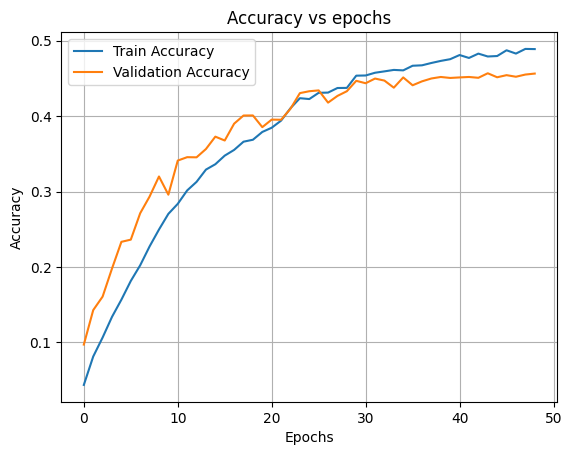

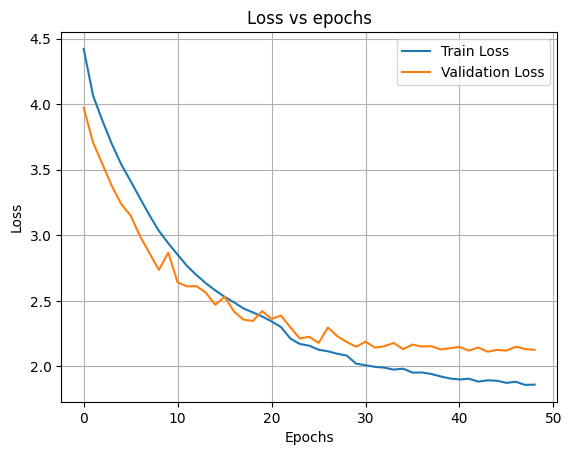

In [28]:
# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

Gráfico da loss vs epochs, mostra indícios de overfitting a partir dos ~25 epochs. Sem usar a reduce_lr, os resultados não têm tanto overfitting, testar depois com diferentes parâmetros na reduce_lr. Talvez fazer um gráfico sobre a learning rate e a performance e depois usar os melhores parâmetros a partir de lá

Classification Report

In [37]:
print(classification_report(y_val, y_pred_classes))

              precision    recall  f1-score   support

           0       0.73      0.70      0.71       112
           1       0.53      0.55      0.54        97
           2       0.27      0.28      0.28        89
           3       0.23      0.26      0.24        94
           4       0.20      0.26      0.23        90
           5       0.44      0.48      0.46        96
           6       0.37      0.39      0.38        92
           7       0.44      0.37      0.40        94
           8       0.52      0.51      0.51       100
           9       0.58      0.59      0.59        90
          10       0.41      0.34      0.37       110
          11       0.36      0.22      0.27       104
          12       0.53      0.43      0.47        95
          13       0.42      0.40      0.41        91
          14       0.44      0.38      0.41       103
          15       0.38      0.23      0.29       108
          16       0.46      0.43      0.44        87
          17       0.49    

Guardar o modelo

In [ ]:
melhor_model.save('cifar10_CNN_sda.keras')